<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/RNN_ReviewTokoBaju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk scikit-learn matplotlib

#PyTorch

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import nltk
import re
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm

nltk.download('punkt_tab')

nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
df = pd.read_csv("/content/ReviewTokoBaju.csv")

df = df[['Review Text', 'Recommended IND']].dropna()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

df['tokens'] = df['Review Text'].apply(clean_text)

all_words = [word for tokens in df['tokens'] for word in tokens]
vocab = Counter(all_words)
vocab = {word: i+2 for i, (word, _) in enumerate(vocab.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode_tokens(tokens, vocab, max_len=100):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

df['encoded'] = df['tokens'].apply(lambda x: encode_tokens(x, vocab))

X = np.array(df['encoded'].tolist())
y = df['Recommended IND'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = torch.tensor(reviews, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]

batch_size = 64

train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)

vocab_size = len(vocab)
model = RNNClassifier(vocab_size, embed_dim=128, hidden_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RNNClassifier(
  (embedding): Embedding(10002, 128, padding_idx=0)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0  # Initialize correct_train for this epoch
    total_train = 0    # Initialize total_train for this epoch
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate and accumulate correct predictions for training accuracy
        predicted = (outputs >= 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(epoch_loss / len(train_loader))
    train_accuracy = correct_train / total_train # Calculate training accuracy for this epoch
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0
    correct_test = 0   # Initialize correct_test for this epoch
    total_test = 0     # Initialize total_test for this epoch
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate and accumulate correct predictions for test accuracy
            predicted = (outputs >= 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy = correct_test / total_test # Calculate test accuracy for this epoch
    test_accuracies.append(test_accuracy)

    # Print both loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracy:.4f}")

100%|██████████| 283/283 [00:23<00:00, 12.04it/s]


Epoch 1/5, Train Loss: 0.4417, Train Acc: 0.8271, Test Loss: 0.4926, Test Acc: 0.8088


100%|██████████| 283/283 [00:21<00:00, 13.16it/s]


Epoch 2/5, Train Loss: 0.4271, Train Acc: 0.8343, Test Loss: 0.5040, Test Acc: 0.8000


100%|██████████| 283/283 [00:22<00:00, 12.66it/s]


Epoch 3/5, Train Loss: 0.4239, Train Acc: 0.8365, Test Loss: 0.5027, Test Acc: 0.8090


100%|██████████| 283/283 [00:22<00:00, 12.55it/s]


Epoch 4/5, Train Loss: 0.4244, Train Acc: 0.8383, Test Loss: 0.5291, Test Acc: 0.8006


100%|██████████| 283/283 [00:22<00:00, 12.64it/s]


Epoch 5/5, Train Loss: 0.4108, Train Acc: 0.8445, Test Loss: 0.5487, Test Acc: 0.7973


In [9]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
        all_preds.extend(outputs)
        all_labels.extend(labels.numpy())

pred_binary = [1 if p >= 0.5 else 0 for p in all_preds]

acc = accuracy_score(all_labels, pred_binary)
prec = precision_score(all_labels, pred_binary)
rec = recall_score(all_labels, pred_binary)
f1 = f1_score(all_labels, pred_binary)
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


Akurasi  : 0.7973
Presisi  : 0.8208
Recall   : 0.9634
F1-Score : 0.8864
AUC      : 0.5054


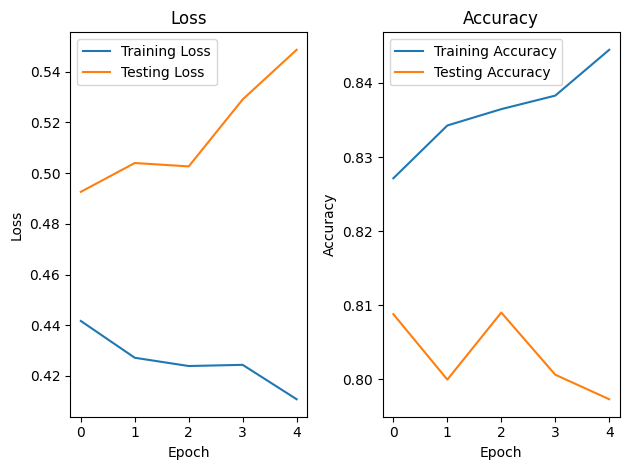

In [10]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#Tensorflow

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# Load data
df = pd.read_csv("/content/ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

df['tokens'] = df['Review Text'].apply(clean_text)

all_words = [word for tokens in df['tokens'] for word in tokens]
vocab = Counter(all_words)
vocab = {word: i+2 for i, (word, _) in enumerate(vocab.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode_tokens(tokens, vocab, max_len=100):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

df['encoded'] = df['tokens'].apply(lambda x: encode_tokens(x, vocab))

X = np.array(df['encoded'].tolist())
y = df['Recommended IND'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
vocab_size = len(vocab)
embed_dim = 128
hidden_dim = 128
max_len = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len),
    SimpleRNN(hidden_dim),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64
)


Epoch 1/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.8086 - loss: 0.4824 - val_accuracy: 0.8207 - val_loss: 0.4722
Epoch 2/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.8147 - loss: 0.4793 - val_accuracy: 0.8207 - val_loss: 0.4724
Epoch 3/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.8208 - loss: 0.4600 - val_accuracy: 0.8183 - val_loss: 0.4806
Epoch 4/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.8305 - loss: 0.4423 - val_accuracy: 0.8178 - val_loss: 0.4822
Epoch 5/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.8343 - loss: 0.4349 - val_accuracy: 0.8059 - val_loss: 0.5030


In [15]:
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Akurasi  : 0.8059
Presisi  : 0.8200
Recall   : 0.9782
F1-Score : 0.8922
AUC      : 0.5244


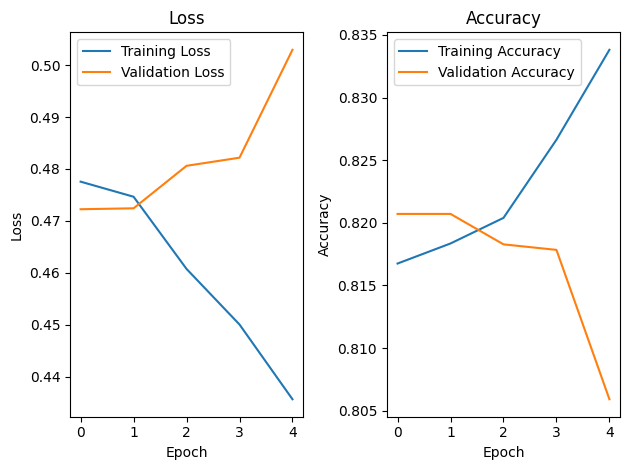

In [16]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()